In [1]:
## Import Packages
import numpy as np
import _pickle as pk
import warnings
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import matplotlib as mpl
from itertools import repeat
from netCDF4 import Dataset
import scipy as sci

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table

#plt.rcParams['axes.xmargin'] = 0 #default margin spacing for the edges
mpl.rc('font',size=35,**{'family':'sans-serif','sans-serif':['Arial']})
#mpl.rc('text', usetex=True)
#mpl.rcParams['mathtext.rm'] = 'Arial'
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)
%matplotlib inline

In [2]:
#Mods = ['CanESM2','CanESM5_p1','CanESM5_p2',\
        #'CanESM5_p3','CanESM5_p4','CanESM5_p5','CanESM5_p6']
Mods = ['CanESM2','CanESM5_p2']

Source = '/Volumes/eSSD0/Papers/GMD_CanESM_p1/'
FNET = dict()
FNETCS = dict()
Tas = dict()
for m in range(len(Mods)):
    FNET[Mods[m]] = pk.load(open(Source+'Data/'+Mods[m]+'/ERF/'+Mods[m]+'_FNET_GAM.pi','rb'))
    FNETCS[Mods[m]] = pk.load(open(Source+'Data/'+Mods[m]+'/ERF/'+Mods[m]+'_FNETCS_GAM.pi','rb'))
    Tas[Mods[m]] = pk.load(open(Source+'Data/'+Mods[m]+'/ERF/'+Mods[m]+'_TAS_GAM.pi','rb'))

In [3]:
def LinReg_wrap(predictand,predictor):
    fit = LinearRegression().fit(predictor,predictand)
    return fit.coef_, fit.intercept_

def LinReg_pred_wrap(predictand,predictor):
    fit = LinearRegression().fit(predictor,predictand)
    
    ECS = -(fit.intercept_/fit.coef_)
    prediction = fit.predict(np.linspace(0,ECS))
    return prediction,ECS

In [4]:
#total sky

alpha = dict()
ERF = dict()
line = dict()
ECS = dict()

alphaCS = dict()
ERFCS = dict()
lineCS = dict()
ECSCS = dict()
for mods in FNET.keys():
    alpha[mods],ERF[mods] = LinReg_wrap(FNET[mods],Tas[mods].reshape(-1,1))
    line[mods],ECS[mods] = LinReg_pred_wrap(FNET[mods],Tas[mods].reshape(-1,1))
    
    alphaCS[mods],ERFCS[mods] = LinReg_wrap(FNETCS[mods],Tas[mods].reshape(-1,1))
    lineCS[mods],ECSCS[mods] = LinReg_pred_wrap(FNETCS[mods],Tas[mods].reshape(-1,1))

#use stats mod to generate a confidence interval for the diagnostic data

statsmods_CanESM2_d = sm.OLS(FNET_CanESM2_d,sm.add_constant(Tas_CanESM2_d))
results_CanESM2_d = statsmods_CanESM2_d.fit()
prediction_CanESM2_d = results_CanESM2_d.predict(sm.add_constant(np.linspace(0,ECS_CanESM2_d,50)))

st, data, ss2 = summary_table(results_CanESM2_d, alpha=0.05)
predict_ci_low, predict_ci_upp = data[:, 6:8].T

In [5]:
alphaCS

{'CanESM2': array([-1.15928841]), 'CanESM5_p2': array([-1.04846583])}

## Clear Sky Linearity Test

In [6]:
#fb = ['TrALB_FLUX','TrWV_FLUX','PLANCK_FLUX','LAPSE_FLUX','SrTEMP_FLUX','SrWV_FLUX','TrCL_FLUX']
fb = ['TrALB_FLUXCS','TrWV_FLUXCS','PLANCK_FLUXCS','LAPSE_FLUXCS','SrTEMP_FLUXCS','SrWV_FLUXCS']
ker = ['CAM3','CAM5','ECHAM6_ctr','GFDL','HadGEM2','ERA']

All_fluxes_CS = dict()
#All_fluxes = dict()
for m in range(len(Mods)):
    All_fluxes_CS[Mods[m]] = dict()
    #All_fluxes[Mods[m]] = dict()
    for k in range(len(ker)):
        All_fluxes_CS[Mods[m]][ker[k]] = dict()
        #All_fluxes[Mods[m]][ker[k]] = dict()
        for i in range(len(fb)):
            All_fluxes_CS[Mods[m]][ker[k]][fb[i]] = pk.load(open(Source+\
            'Data/'+Mods[m]+'/Fluxes/'+Mods[m]+'_ALL_uFLUXES_GAM.pi','rb'))[fb[i]][ker[k]]
            
            #All_fluxes[Mods[m]][ker[k]][fb[i]] = pk.load(open(\
            #'Data/'+Mods[m]+'/Fluxes/'+Mods[m]+'_ALL_uFLUXES_GAM.pi','rb'))[fb[i]][ker[k]]

In [7]:
SumCS = dict()
#Sum = dict()
for mods in All_fluxes_CS.keys():
    SumCS[mods] = dict()
    #Sum[mods] = dict()
    for kernels in All_fluxes_CS[mods].keys():
        SumCS[mods][kernels] = np.sum(list(All_fluxes_CS[mods][kernels].values()),axis=0)
        #Sum[mods][kernels] = np.sum(list(All_fluxes[mods][kernels].values()),axis=0)

In [8]:
def LinReg_int_wrap(predictand,predictor):
    fit = LinearRegression().fit(predictor,predictand)
    return fit.intercept_

def LinReg_alpha_wrap(predictand,predictor):
    fit = LinearRegression().fit(predictor,predictand)
    return fit.coef_

## Regress clear sky global mean fluxes to get slopes

In [9]:
alphaCS_kernel = dict()
#alpha_kernel = dict()
error = dict()
for mods in FNET.keys():
    alphaCS_kernel[mods] = dict()
    #alpha_kernel[mods] = dict()
    error[mods] = dict()
    for kernels in All_fluxes_CS[mods].keys():
        alphaCS_kernel[mods][kernels] = LinReg_alpha_wrap(\
                                SumCS[mods][kernels],Tas[mods].reshape(-1,1))
        #alpha_kernel[mods][kernels] = LinReg_alpha_wrap(\
        #                        Sum[mods][kernels],Tas[mods].reshape(-1,1))
        error[mods][kernels] = alphaCS[mods]-alphaCS_kernel[mods][kernels]

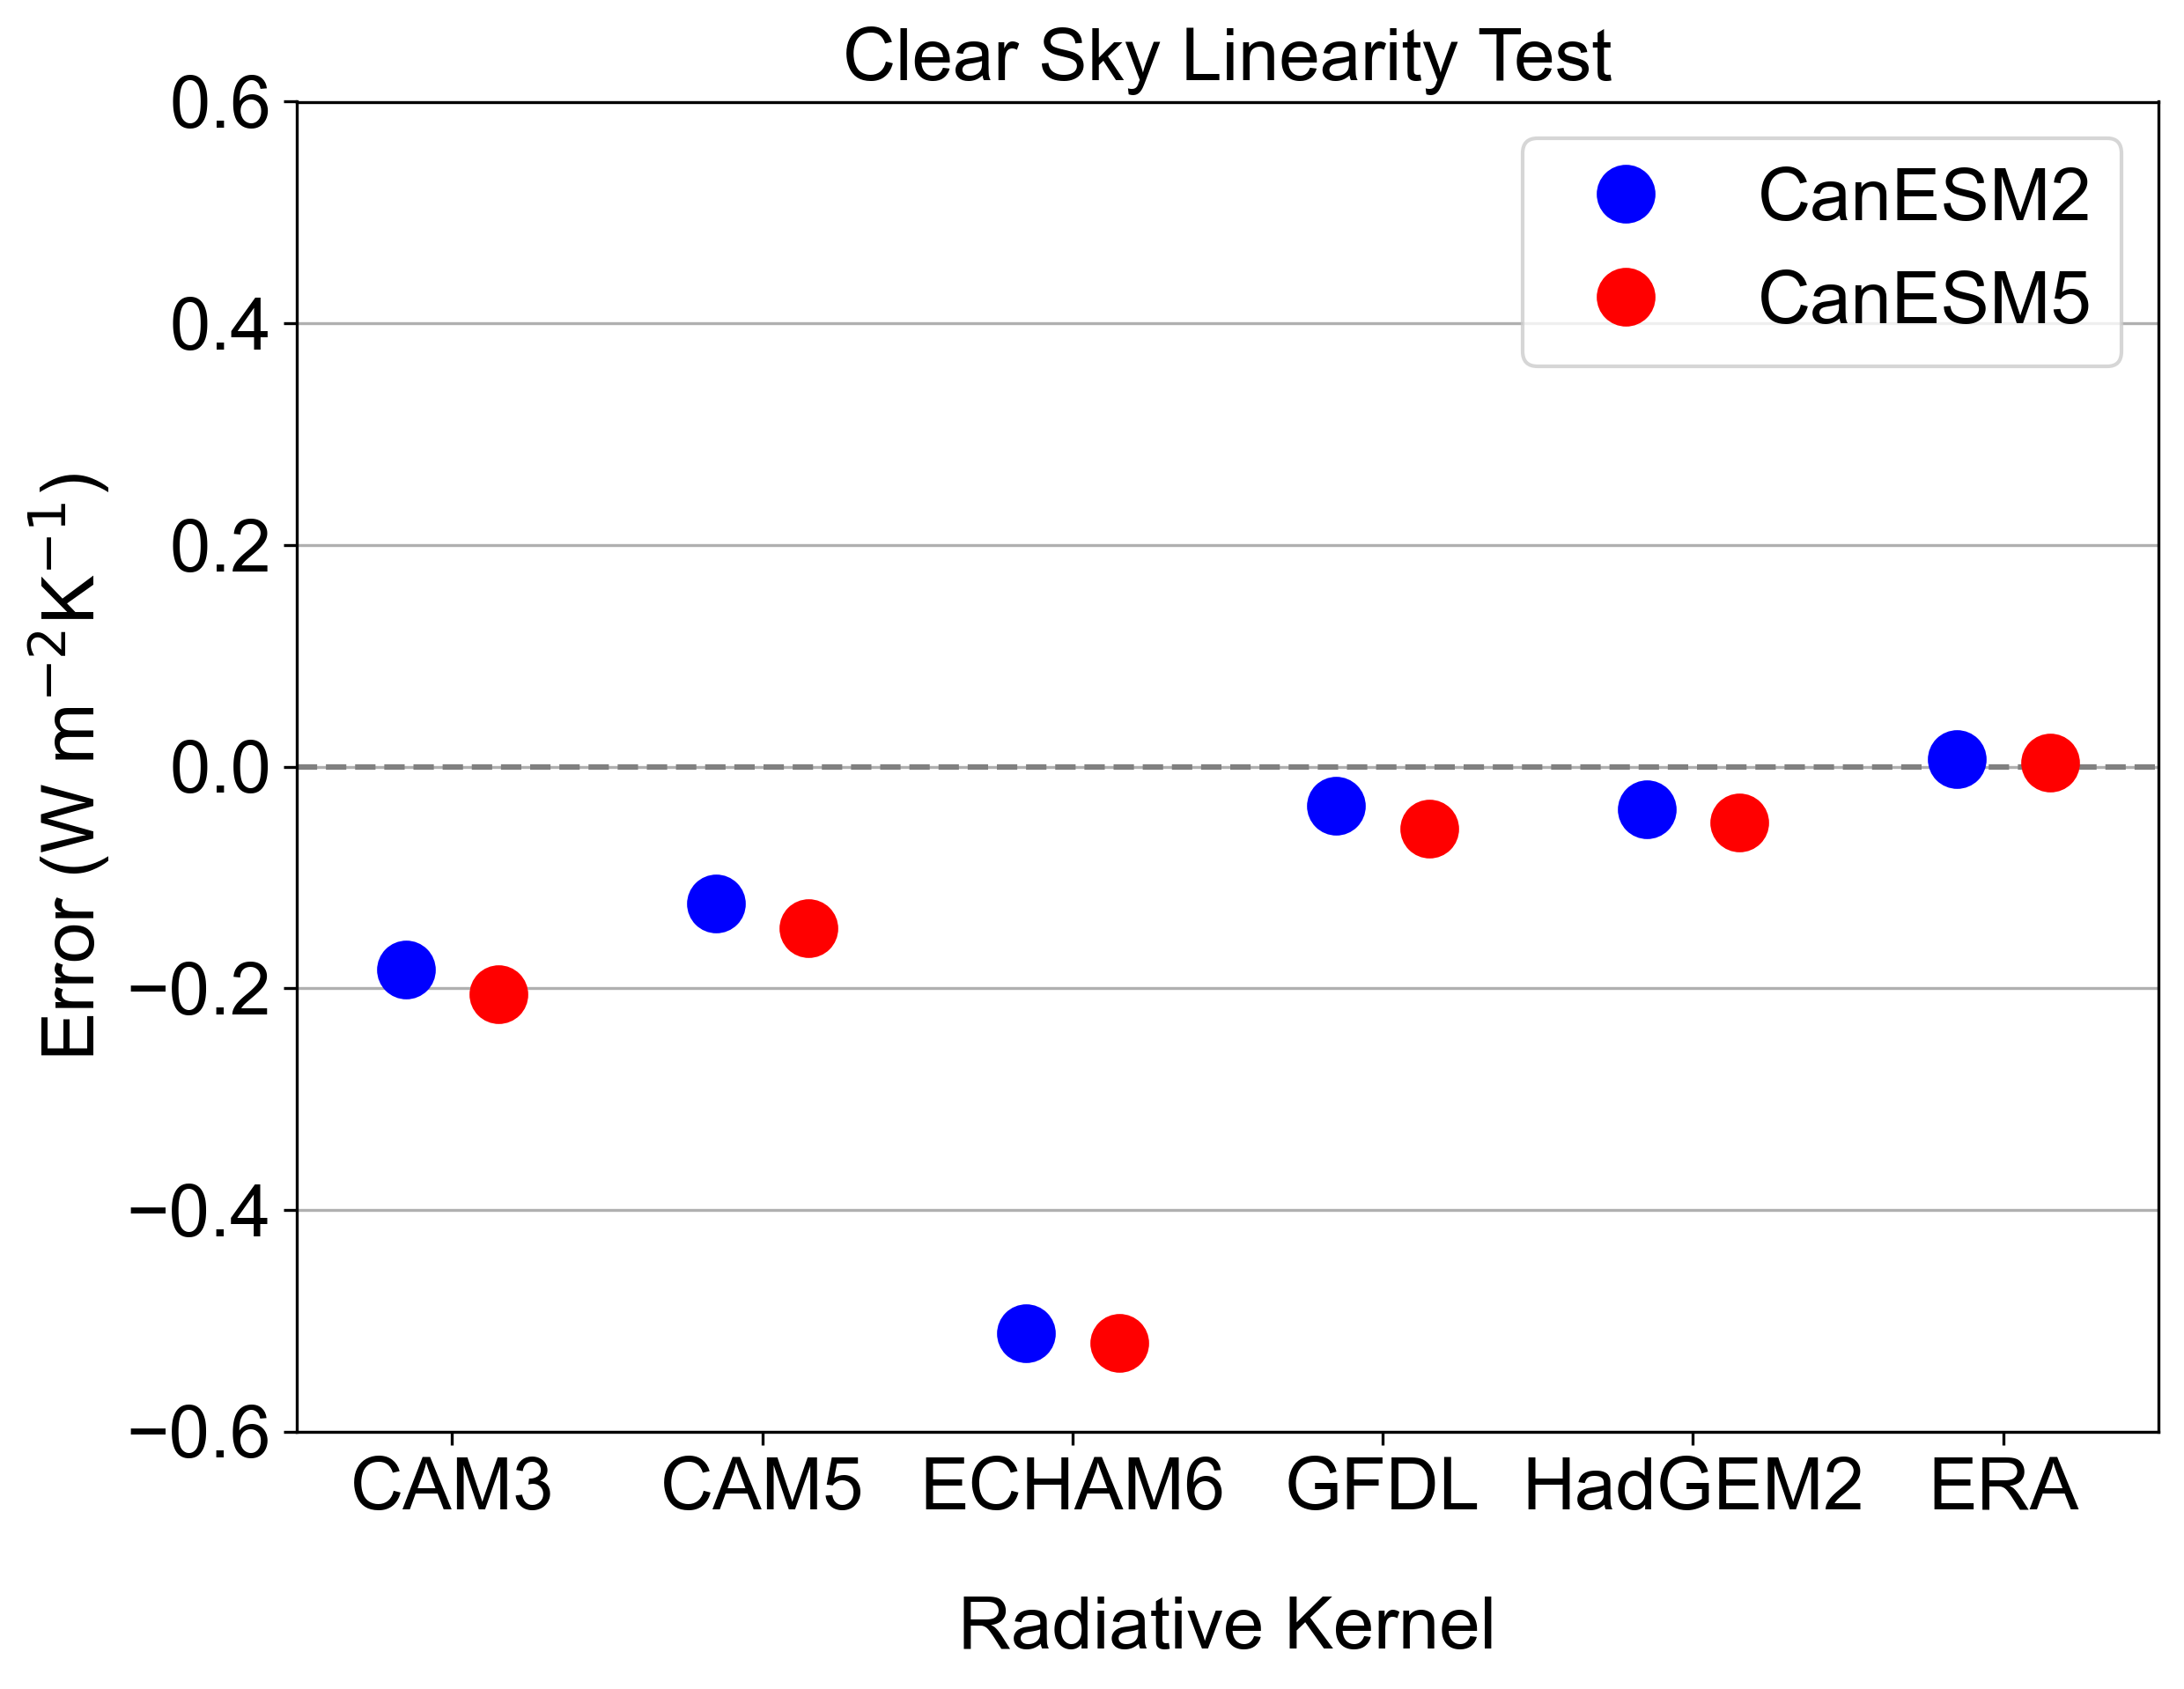

In [12]:
plt.figure(figsize=(20,20/3),dpi=300)
plt.subplot(121)
plt.title('Clear Sky Linearity Test',fontsize=20)
plt.axhline(0,linestyle='--',color='grey')

#data
plt.plot(np.arange(0.35,6.1),list(error['CanESM2'].values()),'o',\
            color='Blue',label='CanESM2',markersize=15)
plt.plot(np.arange(0.65,6.2),list(error['CanESM5_p2'].values()),'o',\
            color='Red',label='CanESM5',markersize=15)

plt.ylim(-0.6,0.6)
plt.xlim(0,6)
Kernels_l = ['CAM3','CAM5','ECHAM6','GFDL','HadGEM2','ERA']
plt.xticks(np.arange(0.5,6.1),labels=Kernels_l,fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Radiative Kernel',labelpad=20,fontsize=20)
plt.ylabel('Error (W m$^{-2}$K$^{-1}$)',fontsize=20)
plt.grid(axis='y')
plt.legend(fontsize=20);

plt.savefig('CS_LinTest.png',bbox_inches='tight')